# Claude Haiku 3.5 with v2.13 prompt

This notebook outlines the steps undertook to generate a prediction using Claude Haiku 3.5 with prompt from 2/13/25.

The v2.13 prompt revamped the baseline prompt to include more definitions and detailed instructions based on analysis of failed predictions from the baseline prompt. Also uses HTML tags to identify different section (as suggested by the Anthropic documentation) & added two examples to create a few-shots prompt.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from prediction_utils import predict
from evaluate_predictions import show_metrics

from instructions import claude_instructions_v213
MODEL_ID = "anthropic.claude-3-5-haiku-20241022-v1:0"
SYSTEM_PROMPT = claude_instructions_v213

# Load the data

In [2]:
df = pd.read_csv("data/dataset.csv")
df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN


# Use the model to generation predictions

In [3]:
%%time
predictions = predict(df, MODEL_ID, SYSTEM_PROMPT)
predictions[:2]

INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:Loading cached SSO token for flp-sso
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:botocore.tokens:SSO Token refresh succeeded
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 4
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022-v1:0/invoke "HTTP/1.1 200 OK"
INFO:root:Completed: 2
INFO:httpx:HTTP Request: POST https://bedrock-runtime.us-west-2.amazonaws.com/model/anthropic.claude-3-5-haiku-20241022

CPU times: user 50.1 s, sys: 6.94 s, total: 57.1 s
Wall time: 24min 38s


[{'0005.91306_cites_88693.txt': {'model': 'claude-3-5-haiku-20241022',
   'input_tokens': 2545,
   'output_tokens': 98,
   'prediction': 'no',
   'confidence': 0.9,
   'rationale': "The passage discusses the Target Case (Huntington v. Texas) in detail, but does not explicitly overrule it. Instead, the passage provides further clarification and nuanced interpretation of previous decisions related to the bonds, without negating or reversing the Target Case's fundamental holding.",
   'raw_results': '```json\n{\n  "overruled": "no",\n  "confidence": 0.9,\n  "rationale": "The passage discusses the Target Case (Huntington v. Texas) in detail, but does not explicitly overrule it. Instead, the passage provides further clarification and nuanced interpretation of previous decisions related to the bonds, without negating or reversing the Target Case\'s fundamental holding."\n}\n```'}},
 {'0003.91306_cites_87633.txt': {'model': 'claude-3-5-haiku-20241022',
   'input_tokens': 2574,
   'output_toke

In [4]:
prediction_df = pd.DataFrame([
    {"filename": filename, **details} 
    for prediction in predictions 
    for filename, details in prediction.items()
])
prediction_df.head()

,filename,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0005.91306_cites_88693.txt,claude-3-5-haiku-20241022,2545,98,no,0.90,The passage discusses the Target Case (Hunting...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
1,0003.91306_cites_87633.txt,claude-3-5-haiku-20241022,2574,122,no,0.95,The passage discusses the case Murray v. Lardn...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
2,0001.91306_cites_88061.txt,claude-3-5-haiku-20241022,3376,102,yes,0.95,The passage explicitly states that the origina...,"```json\n{\n ""overruled"": ""yes"",\n ""confiden..."
3,0002.91306_cites_88994.txt,claude-3-5-haiku-20241022,3057,121,no,0.80,The passage discusses the Target Case (Vermily...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
4,0004.91306_cites_88240.txt,claude-3-5-haiku-20241022,2540,200,no,0.80,The passage mentions the Target Case (Texas v....,"Based on the passage, here's the analysis for ..."


## Save the raw prediction results

In [5]:
prediction_df.to_csv("predictions/1.claude/1.haiku3.5_v213_prompt.csv", index=False)

## Check if any datapoints did not get prediction results and need to be re-predicted or cleaned

In [6]:
prediction_df["prediction"].isna().sum()

1

In [8]:
# Here I manually reviewed these cases in Google Sheets and replaced with the cleaned version
prediction_df = pd.read_csv("predictions/1.claude/1.haiku3.5_v213_prompt.csv")

In [9]:
prediction_df["prediction"].isna().sum()

0

# Combine the prediction results with label for evaluation

In [10]:
assert len(df) == len(prediction_df)

In [11]:
eval_df = df.merge(prediction_df, how="left", on="filename")
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-haiku-20241022,3376,102,yes,0.95,The passage explicitly states that the origina...,"```json\n{\n ""overruled"": ""yes"",\n ""confiden..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-haiku-20241022,3057,121,no,0.80,The passage discusses the Target Case (Vermily...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-haiku-20241022,2574,122,no,0.95,The passage discusses the case Murray v. Lardn...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-haiku-20241022,2540,200,no,0.80,The passage mentions the Target Case (Texas v....,"Based on the passage, here's the analysis for ..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-haiku-20241022,2545,98,no,0.90,The passage discusses the Target Case (Hunting...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."


# Run evaluation

In [12]:
df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [13]:
eval_df["overruled"].value_counts()

overruled
no     935
yes    149
Name: count, dtype: int64

In [14]:
eval_df["prediction"].value_counts()

prediction
no     905
yes    179
Name: count, dtype: int64

In [15]:
eval_df["input_tokens"].sum()

4094894

In [16]:
eval_df["output_tokens"].sum()

252836

In [17]:
y_true = eval_df["overruled"].map({"yes": 1, "no": 0})
y_pred = eval_df["prediction"].map({"yes": 1, "no": 0, "partially": 1})

In [18]:
report = classification_report(y_true, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.96      0.93      0.94       935
         Yes       0.63      0.75      0.68       149

    accuracy                           0.90      1084
   macro avg       0.79      0.84      0.81      1084
weighted avg       0.91      0.90      0.91      1084



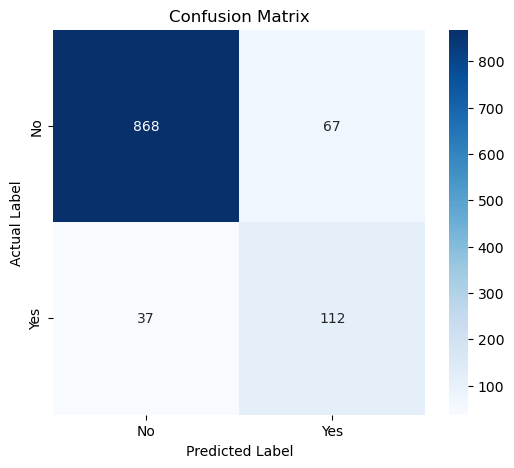

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
show_metrics(cm, y_true)

precision: of all predicted positives, how many were actual positives
recall: of all actual positives, how many we predicted to be positives
---------
METRICS
Accuracy: 0.90
Precision: 0.63
Recall: 0.75
F-score: 0.68
Specificity: 0.93
---------
DATASET
Total Responses: 1084
Total Positives: 149
Total Negatives: 935
---------
RECOUNT
True positives: 112
True negatives: 868
False positives: 67
False negatives: 37


In [21]:
confidently_wrong_positive = (eval_df["prediction"] == "yes") & (eval_df["overruled"] == "no") & (eval_df["confidence"] >= 0.8)
confidently_wrong_positive.sum()

67

In [22]:
confidently_wrong_negative = (eval_df["prediction"] == "no") & (eval_df["overruled"] == "yes") & (eval_df["confidence"] >= 0.8)
confidently_wrong_negative.sum()

33

# Save the evaluation df

In [23]:
eval_df.head()

,filename,citing_opinion_id,citing_index,court,docket_id,cluster_id,citing_decision_name,cited_opinion_id,cited_index,depth,cited_decision_name,overruled,notes,model,input_tokens,output_tokens,prediction,confidence,rationale,raw_results
0,0001.91306_cites_88061.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88061,0,3,Texas v. White (1869),yes,NaN,claude-3-5-haiku-20241022,3376,102,yes,0.95,The passage explicitly states that the origina...,"```json\n{\n ""overruled"": ""yes"",\n ""confiden..."
1,0002.91306_cites_88994.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88994,1,2,Vermilye & Co. v. Adams Express Co. (1875),no,NaN,claude-3-5-haiku-20241022,3057,121,no,0.80,The passage discusses the Target Case (Vermily...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
2,0003.91306_cites_87633.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",87633,2,1,Murray v. Lardner (1865),no,NaN,claude-3-5-haiku-20241022,2574,122,no,0.95,The passage discusses the case Murray v. Lardn...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."
3,0004.91306_cites_88240.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88240,3,1,Texas v. Hardenberg (1869),no,NaN,claude-3-5-haiku-20241022,2540,200,no,0.80,The passage mentions the Target Case (Texas v....,"Based on the passage, here's the analysis for ..."
4,0005.91306_cites_88693.txt,91306,0,scotus,2297559,91306,"Morgan v. United States,113 U.S. 476 (1885)",88693,4,1,Huntington v. Texas (1873),no,NaN,claude-3-5-haiku-20241022,2545,98,no,0.90,The passage discusses the Target Case (Hunting...,"```json\n{\n ""overruled"": ""no"",\n ""confidenc..."


In [24]:
eval_df.to_csv("predictions/1.claude/1.haiku3.5_v213_prompt_eval.csv", index=False)